# O que são redes neurais (Neural Nets)?
Redes Neurais são descritas de muitas maneiras. Alguns fazem analogias ao cérebro humano, outros dizem que são a maneira como as máquinas aprendem, outros preferem chama-las de de "Inteligência artificial". 

Veremos que as Redes Neurais artificiais, usadas amplamente em visão computacional, processamento de linguagem natural e outras infinitas áreas da tecnologia, podem e devem ser descritas simplesmente como uma maneira de aproximar uma função.

# Universal Approximation Theorem
O Teorema da aproximação universal é uma teoria matemática que declara que uma rede neural pré-alimentada com uma única camada oculta que contém um número finito de neurônios pode aproximar funções contínuas em subconjuntos compactos de Rⁿ, com pressupostos mínimos de função de ativação. Ou seja, nossas Neural Nets não são nada mais que maneiras de aproximar funções contínuas que nós humanos conhecemos, e principalmente, aquelas as quais não temos capacidade de formular.

## Glossário
 - Função contínua: 
     - "f(x) será chamado de função contínua, se ... os valores numéricos da diferença f(x+α)-f(x) diminuem arbitrariamente, conforme α varie ...".
Em matemática, uma função é contínua quando, intuitivamente, as pequenas variações nos objetos correspondem a pequenas variações nas imagens. Nos pontos onde a função não é contínua, diz-se que a função é descontínua, ou que se trata de um ponto de descontinuidade.

In [2]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Exercício: aproximando a função seno

### Criando o dataset
Abaixo será criado um vetor aleatório com 30000 valores aleatórios, associaremos a esses valores o seu seno e adicionaremos junto a este seno um ruído para cada x do vetor inicial.

x min:  [-8.99979689]
x max: [8.99917733]
y min:  [-1.18706716]
y max: [1.16294006]


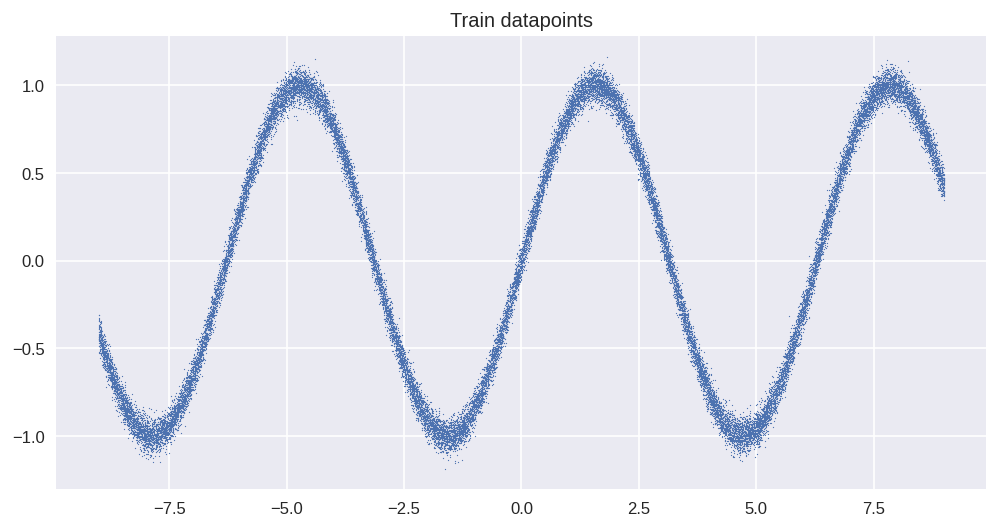

In [5]:
n_x_train = 30000   # the number of training datapoints
n_x_test = 8000     # the number of testing datapoints

x_train = np.random.rand(n_x_train,1)*18 - 9#*50 - 25  # Initialize a vector of with dimensions [n_x, 1] and extend
y_train = (np.sin(x_train)) # Calculate the sin of all data points in the x vector and reduce amplitude
y_train += (np.random.randn(n_x_train, 1)/20) # add noise to each datapoint

x_test = np.random.rand(n_x_test, 1)*18 -9 #*50 - 25  # Repeat data generation for test set
y_test = (np.sin(x_test))
y_real = np.sin(x_test)
y_test += (np.random.randn(n_x_test, 1)/20)

print("x min: ", min(x_train))
print("x max:", max(x_train))
print("y min: ", min(y_train))
print("y max:", max(y_train))

figure(figsize=(10, 5), dpi=120)
plt.style.use('seaborn')
plt.scatter(x_train, y_train, marker='o', s=0.2) 
plt.title("Train datapoints")
plt.show()  

### Criando a classe Dataset do PyTorch
Abaixo é criado um dataset padrão do PyTorch. Esta é uma classe que precisa de dois magicmethods, __getitem__ e __len__. A função desta classe é simplesmente servir como base para a classe DataLoader do PyTorch utilizar o método __getitem__ e retornar um item no treinamento (x e sen(x)). A classe dataloader do PyTorch é responsável por organizar estes itens em batches e também de algumas métricas.

In [6]:
class SineDataset(Dataset):
    def __init__(self, x, y):
        x_dtype = torch.FloatTensor
        y_dtype = torch.FloatTensor # for MSE or L1 Loss
        self.length = x.shape[0]
        self.x_data = torch.from_numpy(x).type(x_dtype)
        self.y_data = torch.from_numpy(y).type(y_dtype)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.length

### Treinamento
Abaixo definimos os métodos de treinamento e teste.

In [7]:
def train_batch(model, x, y, optimizer, loss_fn):
    # Run forward calculation
    y_predict = model.forward(x)
    # Compute loss and do backward pass.
    loss = loss_fn(y_predict, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.data.item()

def train(model, loader, optimizer, loss_fn, epochs=10):
    losses = []
    batch_index = 0
    for e in range(epochs):
        for x, y in loader:
            loss = train_batch(model=model, x=x, y=y, optimizer=optimizer, loss_fn=loss_fn)
            losses.append(loss)
            batch_index += 1
        print("Epoch: ", e+1)
    return losses

def test_batch(model, x, y):
    # run forward calculation
    y_predict = model.forward(x)
    return y, y_predict

def test(model, loader):
    y_vectors = []
    y_predict_vectors = []
    batch_index = 0
    for x, y in loader:
        y, y_predict = test_batch(model=model, x=x, y=y)
        y_vectors.append(y.data.numpy())
        y_predict_vectors.append(y_predict.data.numpy())
        batch_index += 1
    y_predict_vector = np.concatenate(y_predict_vectors)
    return y_predict_vector

In [8]:
def plot_loss(losses, show=True):
    figure(figsize=(10, 5), dpi=120)
    plt.style.use('seaborn')
    fig = plt.gcf()
    fig.set_size_inches(8,6)
    ax = plt.axes()
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    x_loss = list(range(len(losses)))
    plt.plot(x_loss, losses)
    plt.title("loss over epoches")
    if show:
        plt.show()
    plt.close()

In [9]:
class ShallowLinear(nn.Module):
    def __init__(self, net_type: str = "nonlinear3layer"):
        super(ShallowLinear, self).__init__()
        self.net_type = net_type 
        # Define network layer dimensions
        # D_in, H1, H2, H3, D_out = [1, 64, 64, 64, 1] # These numbers correspond to each layer: [input, hidden_1, output]
        D_in, H1, H2, H3, D_out = [1, 16, 16, 16, 1] # each layer: [input, hidden_1, h2, h3, output]
        self.activation = nn.Tanh() 
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.linear4 = nn.Linear(H3, D_out)

    def forward(self, x):
        # Linear forward
        if self.net_type == "linear":
            x = self.linear1(x) 
            x = self.linear4(x) 
        
        # Non linear forward
        if self.net_type == "nonlinear":
            x = self.linear1(x) 
            x = self.activation(x)
            x = self.linear4(x)
        
        # Non linear 3 layer forward
        if self.net_type == "nonlinear3layer":
            x = self.linear1(x)
            x = self.activation(x)
            x = self.linear2(x)
            x = self.activation(x)
            x = self.linear3(x)
            x = self.activation(x)
            x = self.linear4(x)

        return x

def run(dataset_train, dataset_test):
    # Batch size is the number of training examples used to calculate each iteration's gradient
    batch_size_train = 16
    data_loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size_train, shuffle=True)
    data_loader_test = DataLoader(dataset=dataset_test, batch_size=len(dataset_test), shuffle=False)
    
    learning_rate = 1e-3
    shallow_model = ShallowLinear()
    optimizer = optim.Adam(shallow_model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()  # mean squared error
    loss = train(model=shallow_model, loader=data_loader_train, optimizer=optimizer, loss_fn=loss_fn)
    # Test and get the resulting predicted y values
    y_predict = test(model=shallow_model, loader=data_loader_test)
    return shallow_model, loss, y_predict

# Treinamento

In [10]:
dataset_train = SineDataset(x=x_train, y=y_train)
dataset_test = SineDataset(x=x_test, y=y_test)
print("Train set size: ", dataset_train.length)
print("Test set size: ", dataset_test.length)
model, losses, y_predict = run(dataset_train=dataset_train, dataset_test=dataset_test)
print("Final loss:", sum(losses[-100:])/100)

Train set size:  30000
Test set size:  8000
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Final loss: 0.0032679574936628343


# Visualizações

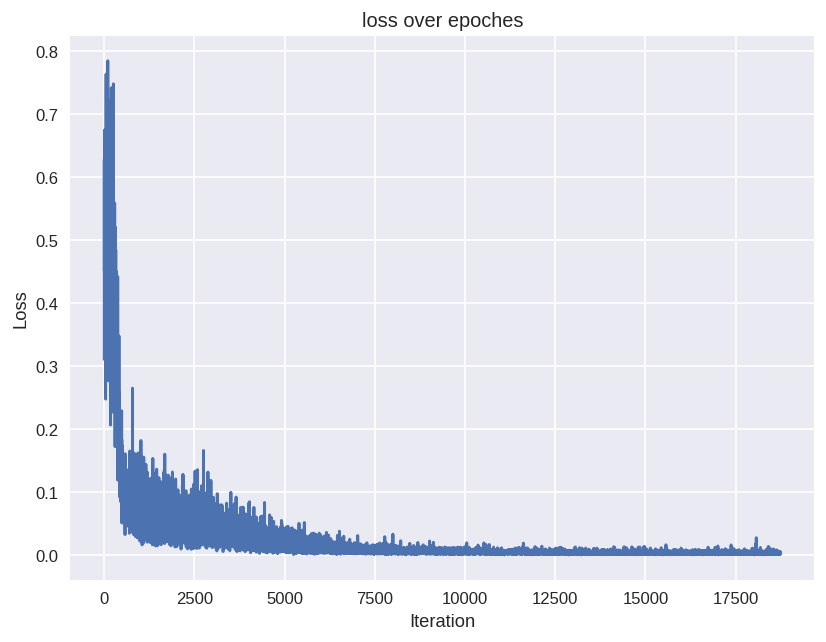

In [11]:
plot_loss(losses)

<Figure size 576x432 with 0 Axes>

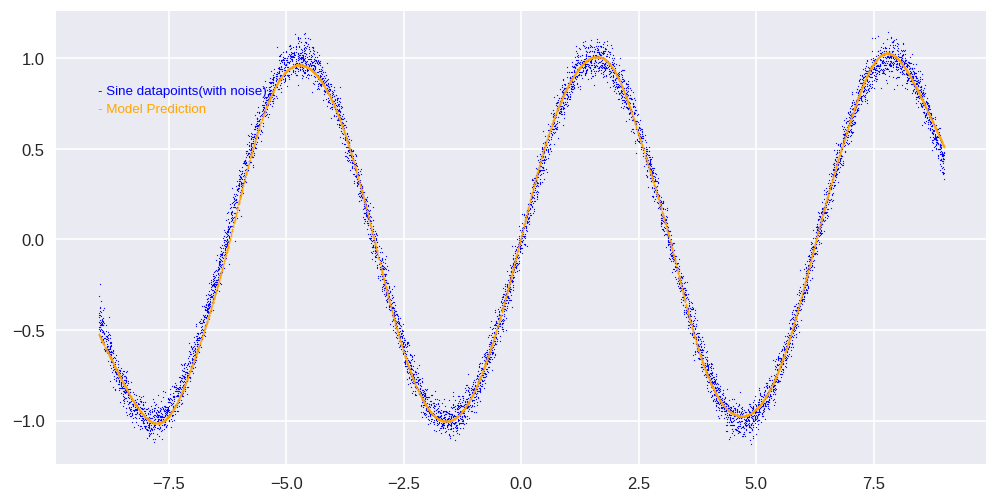

In [13]:
fig2 = plt.figure()
figure(figsize=(10, 5), dpi=120)
plt.style.use('seaborn')
fig2.set_size_inches(8,6)
plt.scatter(x_test, y_test, marker='o', s=0.2, color="blue")
plt.scatter(x_test, y_predict, marker='o', s=0.3, color="orange")
#plt.scatter(x_test, y_real,  marker='o', s=0.3, color="green")
plt.text(-9, 0.7, "- Model Prediction", color="orange", fontsize=8)
plt.text(-9, 0.8, "- Sine datapoints(with noise)", color="blue", fontsize=8)
#plt.text(-9, 0.9, "- Real Sine", color="green", fontsize=8)
plt.show()

# Avalie os ângulos!

In [20]:
values = [(2* math.pi)/x for x in range(1,10)]

def inference(values):
    for value in values:
        angle = torch.tensor([value], dtype=torch.float)
        angle = angle[None,:]
        model_angle = model(angle)
        model_angle = model_angle.detach()[0].numpy()[0]
        
        denominator = int((2*math.pi)/value)
        print(f"Angle: 2π/{denominator} rad")
        print(f"Model sin : {model_angle:.5f}")
        print(f"Real sin  : {math.sin(value):.5f}\n")
    
inference(values)

Angle: 2π/1 rad
Model sin : 0.00855
Real sin  : -0.00000

Angle: 2π/2 rad
Model sin : 0.01382
Real sin  : 0.00000

Angle: 2π/3 rad
Model sin : 0.87293
Real sin  : 0.86603

Angle: 2π/4 rad
Model sin : 1.00927
Real sin  : 1.00000

Angle: 2π/5 rad
Model sin : 0.95336
Real sin  : 0.95106

Angle: 2π/6 rad
Model sin : 0.87321
Real sin  : 0.86603

Angle: 2π/7 rad
Model sin : 0.79667
Real sin  : 0.78183

Angle: 2π/8 rad
Model sin : 0.72857
Real sin  : 0.70711

Angle: 2π/9 rad
Model sin : 0.66913
Real sin  : 0.64279

